In [1]:
# %%configure -f 
# {"driverMemory": "6000M"}

In [1]:
sc.install_pypi_package('pip==22.0.3')
sc.install_pypi_package('tensorflow')
sc.install_pypi_package('scipy')
sc.install_pypi_package('scikit-learn')
sc.install_pypi_package('pandas==0.23.2')
sc.install_pypi_package('numpy==1.17.4')
sc.install_pypi_package('matplotlib==3.3.0')
sc.install_pypi_package('seaborn==0.11.2')
sc.install_pypi_package('scikit-image==0.19.2')
sc.install_pypi_package('sparkdl')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1646663242839_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 89.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Not uninstalling typing-extensions at /usr/local/lib64/python3.7/site-packages, outside environment /tmp/1646663935679-0
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Not uninstalling flatbuffers at /usr/local/lib64/python3.7/site-packages, outside environment /tmp/1646663935679-0
    Can't uninstall 'flatbuffers'. No files were found to unins

In [2]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import pickle

from skimage.transform import resize
from skimage.io import imread
from PIL import Image
# import tensorflow as tf
# from keras.preprocessing import image

from pyspark.sql.functions import input_file_name, regexp_extract, col

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# SparkContext.setCheckpointDir("path to directory")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading Data

## Features

In [7]:
target = (spark.read.json('s3a://lt10-ffhq/features.json')
          .select('id',
#           regexp_extract(input_file_name(), r'.*/(\d+).json', 1).alias('id'),
                 'faceAttributes.age',
                  'faceRectangle.*'))
# target.toPandas()#.set_index('id', inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Images

In [8]:
url = 's3a://lt10-ffhq/Images/*.png'
df = (spark.read.format("image").load(url)
      .withColumn('id', regexp_extract(input_file_name(), r'.*/(\d+).png', 1))
      .join(target, 'id'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Test

In [9]:
df_test = (spark.read.format("image").load('s3a://lt10-ffhq/Images/0000[0-3].png')
      .withColumn('id', regexp_extract(input_file_name(), r'.*/(\d+).png', 1))
      .join(target, 'id'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
test = df_test[['image.data']].toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

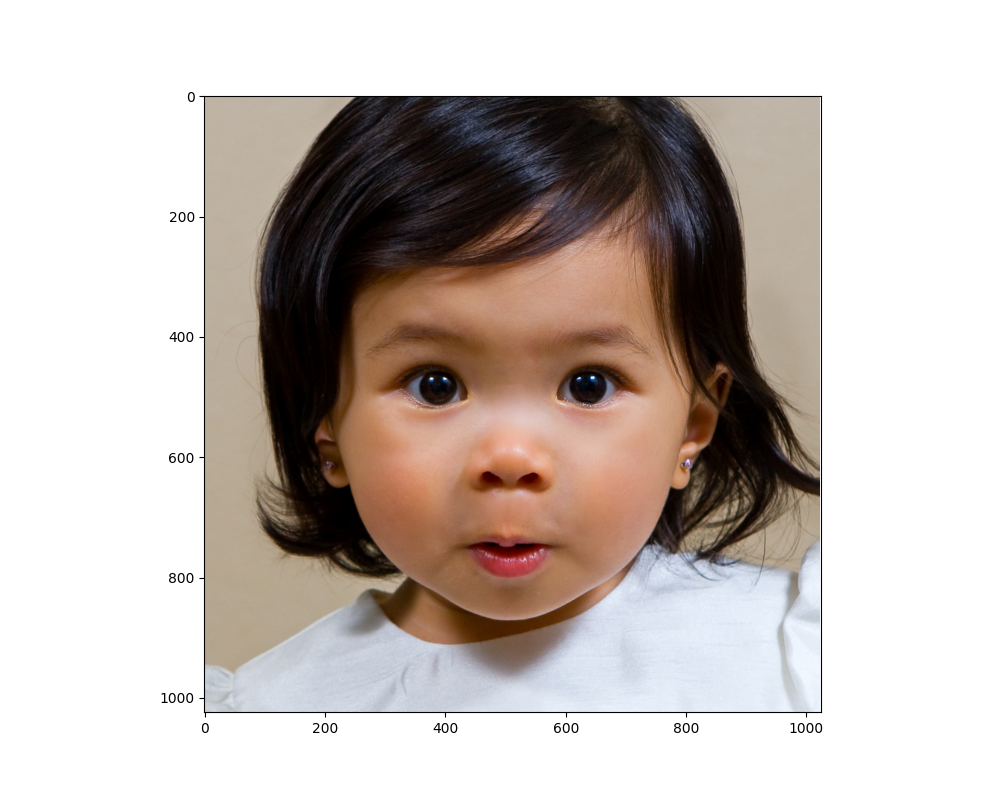

In [16]:
##COLORS WERE SWITCHED change BGR >> RGB
# for n, i in enumerate():
face = np.array(test.data[0]).reshape(1024,1024,3)[:,:,::-1]
face_img = Image.fromarray(face)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face_img)
# plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

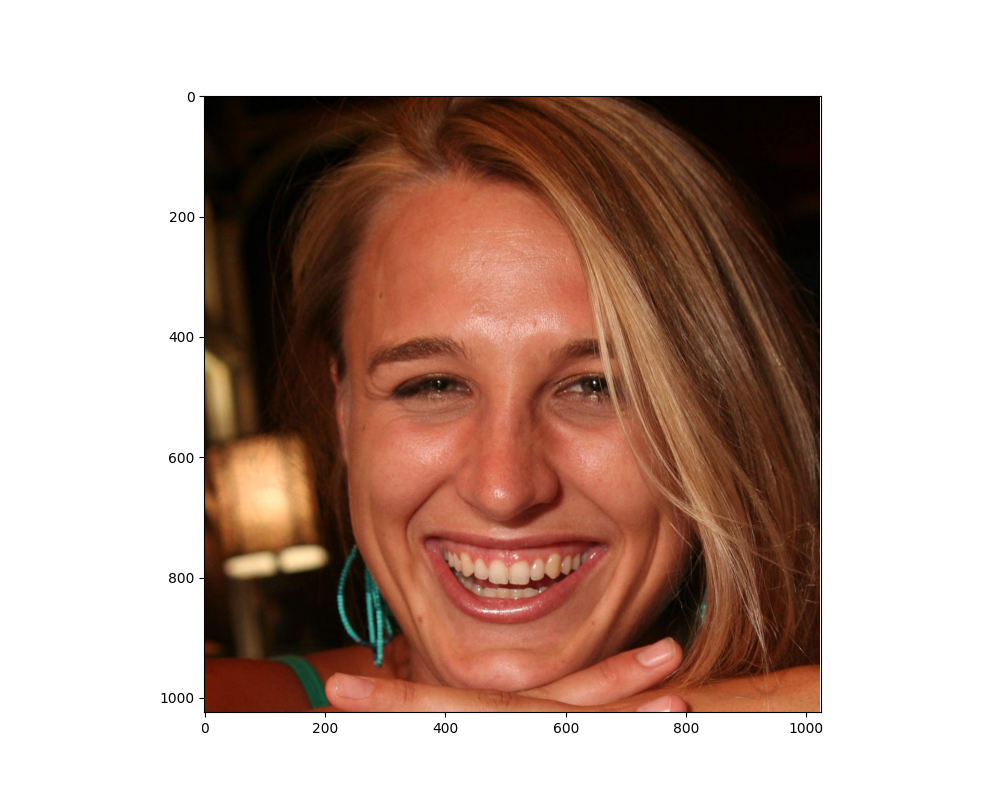

In [19]:
face = np.array(test.data[1]).reshape(1024,1024,3)[:,:,::-1]
face_img = Image.fromarray(face)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face_img)
# plt.show()
%matplot plt

# Creating features

In [17]:
import pyspark.sql.functions as F
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT
 
ImageSchema.imageFields

img2vec = (F.udf(lambda x: DenseVector(
    resize(
        ImageSchema.toNDArray(x[0])[:,:,::-1]
    [x[3]*8:x[3]*8+x[1]*8,x[2]*8:x[2]*8+x[4]*8]
         ,(128, 128), order=1, preserve_range=True, anti_aliasing=True).astype('uint8')
    .flatten()), VectorUDT()))

binary = F.udf(lambda x: 1 if x<=12 else 0)

df = (df.withColumn('vecs', img2vec(F.struct('image', 'height',  'left',  'top',  'width')))
     .withColumn('label', binary('age').astype('int')).select('vecs', 'label'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Test

In [18]:
test2 = df.take(4)
test2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(vecs=DenseVector([44.0, 25.0, 10.0, 48.0, 29.0, 11.0, 51.0, 30.0, 14.0, 55.0, 31.0, 17.0, 57.0, 33.0, 20.0, 59.0, 35.0, 22.0, 65.0, 37.0, 25.0, 65.0, 36.0, 25.0, 66.0, 36.0, 24.0, 66.0, 37.0, 24.0, 69.0, 40.0, 25.0, 69.0, 40.0, 22.0, 69.0, 42.0, 23.0, 71.0, 42.0, 26.0, 75.0, 43.0, 26.0, 76.0, 44.0, 24.0, 78.0, 43.0, 23.0, 78.0, 44.0, 24.0, 77.0, 45.0, 24.0, 78.0, 45.0, 24.0, 79.0, 46.0, 24.0, 80.0, 47.0, 25.0, 79.0, 47.0, 25.0, 78.0, 46.0, 23.0, 79.0, 46.0, 22.0, 79.0, 45.0, 22.0, 77.0, 45.0, 23.0, 79.0, 45.0, 21.0, 77.0, 45.0, 19.0, 78.0, 45.0, 22.0, 80.0, 46.0, 21.0, 81.0, 47.0, 21.0, 83.0, 49.0, 21.0, 83.0, 49.0, 25.0, 84.0, 50.0, 28.0, 86.0, 51.0, 26.0, 87.0, 52.0, 25.0, 90.0, 54.0, 30.0, 92.0, 56.0, 32.0, 93.0, 57.0, 33.0, 95.0, 59.0, 35.0, 99.0, 63.0, 39.0, 101.0, 64.0, 40.0, 101.0, 63.0, 38.0, 105.0, 65.0, 40.0, 108.0, 68.0, 43.0, 112.0, 72.0, 47.0, 113.0, 73.0, 49.0, 116.0, 75.0, 53.0, 117.0, 78.0, 55.0, 120.0, 79.0, 57.0, 122.0, 81.0, 56.0, 121.0, 80.0, 56.0, 120.0, 80.0,

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

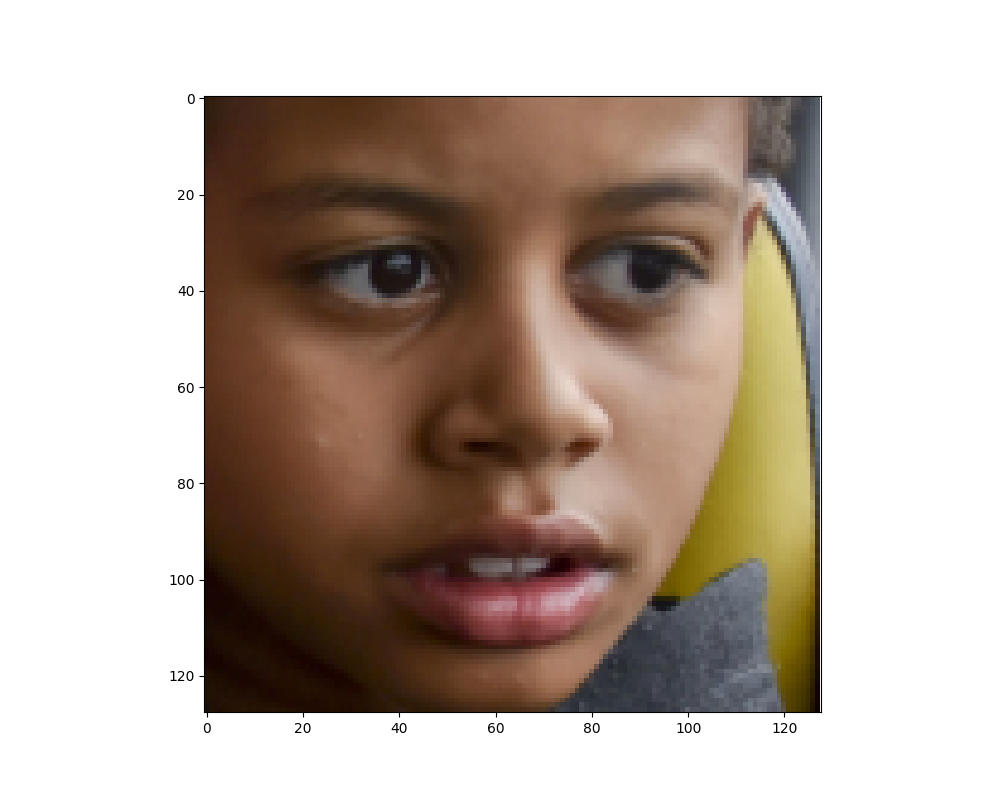

In [20]:
# for i in range(4):
face = test2[0][-2].reshape(128,128,3)
face_img = Image.fromarray(np.uint8(face))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face_img)

plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

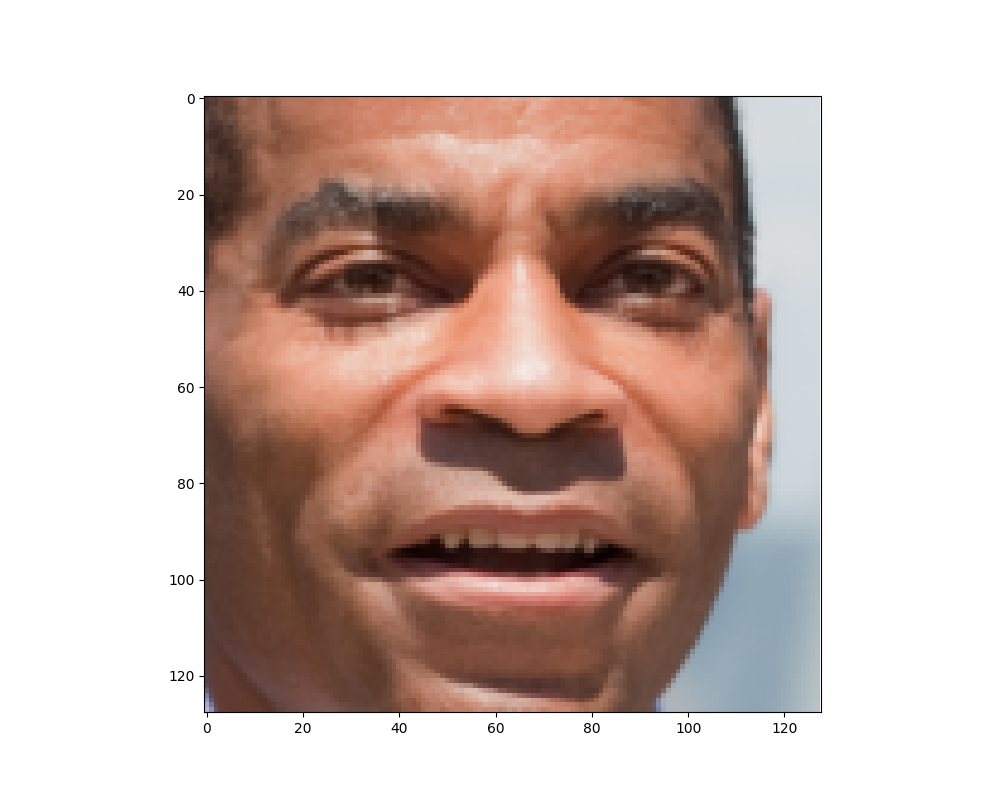

In [21]:
# for i in range(4):
face = test2[1][-2].reshape(128,128,3)
face_img = Image.fromarray(np.uint8(face))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(face_img)

plt.show()
%matplot plt

In [22]:
df.groupby('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1|10811|
|    0|28962|
+-----+-----+

# Model

## Logistic Regression

In [ ]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

df_training, df_test = df.randomSplit([0.8, 0.2], seed=143)

lsvc=LogisticRegression(featuresCol='vecs',
                          labelCol='label')

pipe = Pipeline(stages=[lsvc])

model_trained = pipe.fit(df_training)
df_predict = model_trained.transform(df_test)

df_predict[['label', 'prediction']].show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df_predict.groupby('label','prediction').count().show()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
print('Recall', evaluator.evaluate(df_predict,{evaluator.metricName: "weightedRecall"}))
#evaluation (f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate|
#weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel
#|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss)')

# Grid Search

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression

df_training, df_test = df.randomSplit([0.8, 0.2], seed=143)

lsvc=LinearSVC(featuresCol='vecs',
                          labelCol='label')

pipe = Pipeline(stages=[lsvc

])

paramGrid = (ParamGridBuilder()
                .addGrid(lsvc.regParam, [0.1,1])
                .build())

cv = CrossValidator(estimator=lsvc,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(metricName="weightedRecall"),
                   numFolds=3)
cv_trained = cv.fit(df_training)
# print(cv_trained.bestModel.stages[-1].explainParam('regParam'))

In [ ]:
df_predict = cv_trained.transform(df_test)

df_predict[['label', 'prediction']].show()

In [ ]:
df_predict.groupby('label','prediction').count().show()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
print('Recall', evaluator.evaluate(df_predict,{evaluator.metricName: "weightedRecall"}))
#evaluation (f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate|
#weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel
#|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss)')

# Featurizer

In [ ]:
from sparkdl import DeepImageFeaturizer

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT
from sparkdl import DeepImageFeaturizer

featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")
ImageSchema.imageFields

img2vec = (F.udf(lambda x: DenseVector(
featurizer.fit(x[0])), VectorUDT()))

binary = F.udf(lambda x: 1 if x<=12 else 0)

df = (df.withColumn('vecs', img2vec(F.struct('image', 'height',  'left',  'top',  'width')))
     .withColumn('label', binary('age').astype('int')))
df.show()